# Sistema 2

## Difusión de partículas
En el problema anterior hemos introducido el funcionamiento básico de ESPResSO para realizar simulaciones de partículas únicamente bajo el potencial de interacción Lennard-Jones. Sin embargo, ahora nos planteamos el mismo sistema pero introduciendo el fenómeno de difusión de las partículas cuando se encuentran a una temperatura determinada. Para ello, definiremos los coeficientes de difusión de cada partícula y añadiremos un termostato de Langevin en nuestro sistema.

In [1]:
import espressomd
import numpy as np
import tipus_particules as tp

### Configuración del sistema
Definimos la variable <tt>temperatura</tt> en Kelvins i la constante de gases ideales <tt>R</tt> en J/K·mol. Es importante que las unidades de las variables sean coherentes entre ellas puesto que ESPResSO no predefine las variables del sistema. Por ejemplo, si introducimos una variable en $nm^{3}$ y otra en $dm^{3}$, tu sistema no representará lo que pretendes simular en realidad ya que ESPResSO no trabaja con unidades. Por lo tanto, debemos tener en cuenta las unidades de cada variable en el momento de introducirlas. En la siguiente celda definimos la caja de nuestro sistema en $nm^{3}$, la temperatura en $K$ i la energía en $J/mol$. 

Según las unidades que introduzcas en las variables de tu sistema, las unidades de otras magnitudes también irán definiéndose. Por ejemplo, si definimos la energía, la masa y la longitud del sistema, obtenemos directamente el tiempo con la siguiente ecuación.

\begin{equation}
time = length \sqrt{\dfrac{mass}{energy}}
\end{equation}

Entonces las unidades de los resultados obtenidos durante la integración o el análisis posterior dependrá de las unidades que hayas introducido en tus variables de configuración del sistema. 
Si se utiliza $Kg/mol$ para la masa, $J/(K·mol)$ para la energía y $nm$ para el espacio, las unidades de tiempo estarán dadas en $ns$.

Ten esto presente en el momento de configurar tus sistemas.

In [2]:
#Dimensiones del sistema:
system=espressomd.System(box_l=[10,10,10])   # Inicializamos el sistema. Caja de 10x10x10 nm3

# Parámetros del sistema
temperatura = 300                # en K
R           = 8.314472           # en J/(K mol) 
RT          = temperatura * R    # en J/mol

### Definición y posición de las partículas

In [3]:
#Partículas del sistema

#Código numérico de los tipos de partículas.
type_A = 0     
type_P = 1

#Parámetros de carga
charges = {}
charges[type_A] = 0
charges[type_P] = 0

#Parámetros de masa en kg/mol
mass = {}
mass[type_A] = 3.000   # En kg/mol
mass[type_P] = 0.300   # En kg/mol

# 
D_coeff = {}  # En nm2/ns
D_coeff[type_A] = 0.2      # En nm2/ns  Partículas Lentas
D_coeff[type_P] = 2.0      # En nm2/ns  Partículas Rápidas


# Fricciones. Isotrópicas 

Fric={}
Fric[type_A]=[RT/D_coeff[type_A]]*3
Fric[type_P]=[RT/D_coeff[type_P]]*3

A partir de la temperatura inicial y los coeficientes de difusión, calculamos el coeficiente de fricción. En el momento de definir la partícula, introducimos el coeficiente de fricción en la variable <tt>gamma</tt>. Fíjate que las partículas <tt>type_A</tt> tienen un coeficiente de difusión más pequeño y, por lo tanto, se desplazarán más lentamente respecto las partículas <tt>type_P</tt>.

In [4]:
#Generamos tres partículas A

system.part.add(id=0,type=type_A, pos=[1.0,0.0,0],q=charges[type_A], mass=mass[type_A], gamma=Fric[type_A])
system.part.add(id=1,type=type_A, pos=[4.0,0.0,0],q=charges[type_A], mass=mass[type_A], gamma=Fric[type_A])
system.part.add(id=2,type=type_A, pos=[2.0,4.0,0],q=charges[type_A], mass=mass[type_A], gamma=Fric[type_A])

# Generamos una partícula P
system.part.add(id=3,type=type_P, pos=[2.0,2.0,0],q=charges[type_P], mass=mass[type_P], gamma=Fric[type_P])

### Definición de las interacciones

In [5]:
# Interacciones de volumen excluido: WCA

epsi=1000.     # En J/(K mol)   
diametro=0.2   # En nm
    
system.non_bonded_inter[type_A,type_A].wca.set_params(epsilon=epsi, sigma=diametro)
system.non_bonded_inter[type_A,type_P].wca.set_params(epsilon=epsi, sigma=diametro)

### Integración del sistema
Aparte del integrador, también definimos el termostato de Langevin con el comando <tt>system.thermostat.set_langevin</tt>. Es necesario introducir la temperatura inicial (RT), el coeficiente de fricción del baño (<tt>gamma</tt>) y la semilla para inicializar el baño (<tt>seed</tt>, debe ser positiva).

In [6]:
# Activamos el Modelo Velocity-Verlet
system.integrator.set_vv()

# Activamos el termostáto
Semilla=45
system.thermostat.set_langevin(kT=RT, gamma=1 , seed=Semilla)

In [7]:
system.time_step =     0.00001    # ns
system.cell_system.skin =  0.3  

niter=1
pasos=500

tp.save_vxyz(system,'Trajectory2.xyz','w',aplicar_PBC=False)

coor=[]

for it in range(pasos):
    system.integrator.run(niter)                                    # Realiza niter de dinámica
    tp.save_vxyz(system,'Trajectory2.xyz','a',aplicar_PBC=False)    # Save coordenada
    coor.append(system.part[3].pos)

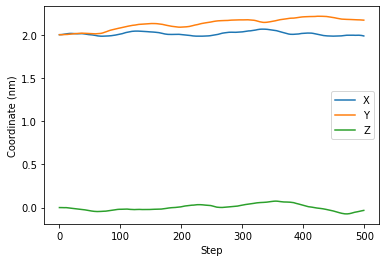

In [8]:
import matplotlib.pyplot as plt
coor=np.array(coor)

plt.ylabel('Coordinate (nm)')
plt.xlabel('Step')
plt.plot(coor)
plt.legend(["X","Y","Z"])

plt.show()

# Práctica

- Realiza otras simulaciones cambiando el coeficiente de difusión en el rango de 2.0 a 0.01 nm2/ns. Cambia la masa de las partículas P a 3 Kg/mol. Visualiza las trayectorias con VMD.
- Incrementa el tiempo de simulación cambiando la variable pasos
